# Search coined algorithm : NxN grid

In [1]:
from qiskit import *
import numpy as np
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.gate import *
import matplotlib.pyplot as plt
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit import Gate
from qiskit.circuit.library import Diagonal

/home/jlucas/.local/lib/python3.6/site-packages/qiskit/__init__.py:66: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of qiskit-terra 0.17.0. Support for running Qiskit with Python 3.6 will be removed in qiskit-terra 0.20.0.
  DeprecationWarning,


## Useful gates

In [2]:
def diffuser(n):
    qr = QuantumRegister(n)
    diffuser = QuantumCircuit(qr)
    
    diffuser.h(qr[:])
    diffuser.x(qr[:])
    diffuser.h(qr[-1])
    diffuser.mct(qr[:-1], qr[-1])  # multi-controlled-toffoli
    diffuser.h(qr[-1])
    diffuser.x(qr[:])
    diffuser.h(qr[:])
    return diffuser.to_gate(label='Diff')

In [3]:
def grover_oracle(n, sol):
    diagonal_elements = [1]*(2**n)
    diagonal_elements[sol]= -1
    oracle = Diagonal(diagonal_elements)
    #print(diagonal_elements)
    oracle.name = "O$_{f}$"
    return oracle.to_gate()

In [4]:
def increment_gate(n):
    q_r = QuantumRegister(n)
    inc = QuantumCircuit(q_r)
    for i in range(n-1,0, -1):
        inc.mct(q_r[:i], q_r[i])
    inc.x(q_r[0])
    
    return inc.to_gate(label='INCREMENT')

In [5]:
def decrement_gate(n):
    q_r = QuantumRegister(n)
    dec = QuantumCircuit(q_r)
    
    dec.x(q_r[0])
    for i in range(1,n):
        dec.mct(q_r[:i], q_r[i])
        
    return dec.to_gate(label='DECREMENT')

In [6]:
def shift_gate(n):
    q_r_1 = QuantumRegister(n)
    q_r_2 = QuantumRegister(n)
    q_c = QuantumRegister(2)
    shift = QuantumCircuit(q_r_1, q_r_2,q_c, name = 'Shift')
    
    dec_j = decrement_gate(n)
    shift.append(dec_j, q_r_1[:])
    
    
    inc_j = increment_gate(n).control(1)
    shift.append(inc_j, [q_c[0]] + q_r_1[:])
    shift.append(inc_j, [q_c[0]] + q_r_1[:])
    
    
    shift.append(inc_j, [q_c[1]] + q_r_1[:])

    
    dec_i = decrement_gate(n).control(1)
    shift.append(dec_i, [q_c[1]] + q_r_2[:])
    
    dec = decrement_gate(n).control(2)
    inc = increment_gate(n).control(2)
    shift.append(inc, q_c[:] + q_r_2[:])
    shift.append(inc, q_c[:] + q_r_2[:])
    shift.append(dec, q_c[:] + q_r_1[:])
    shift.append(dec, q_c[:] + q_r_1[:])
    
    
    #shift.x( q_c[1])
        
    return shift.to_gate(label='SHIFT')

#shift_gate(2).draw(output ='mpl', style="bw", initial_state = True )

## Useful functions

In [9]:
def simulate(circuit):
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend = simulator).result()
    counts = result.get_counts(circuit)
    return counts

In [10]:
def show(n,counts, m=2):
    grid = np.zeros((2**(n),2**(n)))
    for num in list(counts.keys()) :
        i = int(num[m+1:n+m+1], base = 2)
        #i = i if i<2**(n-1) else i-(2**n)
        j = int(num[m+n+2:m+2*n+2], base = 2)
        #j = j if j<2**(n-1) else j-(2**n)
        #print(num, "i ='", i, "',j ='",j,"'", counts[num])
        #grid[i + 2**(n-1)-1,j +2**(n-1)-1]= 1024 - counts[num]
        grid[i,j]+=counts[num]
    print(grid)
    return grid

## Search algorithm 1

We applie 

$U'=S \cdot C' = C_0\otimes (I-2\left|v\right\rangle \left\langle v \right|)$ 


to the initial state :

$\left|\psi _0\right\rangle = H^n\left|0\right\rangle^n H^n\left|0\right\rangle^n  $

where :

$\left|v\right\rangle$ is the marked verticle

$C_0  = \frac{1}{2}\begin{pmatrix}
-1  & 1 & 1 & 1 \\
1  & -1 & 1 & 1 \\
1  & 1 & -1 & 1 \\
1  & 1 & 1 & -1 \\
\end{pmatrix}
$ is the grover's diffusion operator

$S$ is the shift gate defined as :


$S\left|{\rightarrow }\right\rangle \left|{i}\right\rangle \left|{j}\right\rangle =
\left|{\rightarrow }\right\rangle \left|{i+1}\right\rangle \left|{j}\right\rangle$



$S\left|{\leftarrow }\right\rangle \left|{i}\right\rangle \left|{j}\right\rangle =
\left|{\leftarrow }\right\rangle \left|{i-1}\right\rangle \left|{j}\right\rangle$



$S\left|{\uparrow }\right\rangle \left|{i}\right\rangle \left|{j}\right\rangle =
\left|{\uparrow }\right\rangle \left|{i1}\right\rangle \left|{j+1}\right\rangle$



$S\left|{\downarrow }\right\rangle \left|{i}\right\rangle \left|{j}\right\rangle =
\left|{\downarrow }\right\rangle \left|{i}\right\rangle \left|{j-1}\right\rangle$



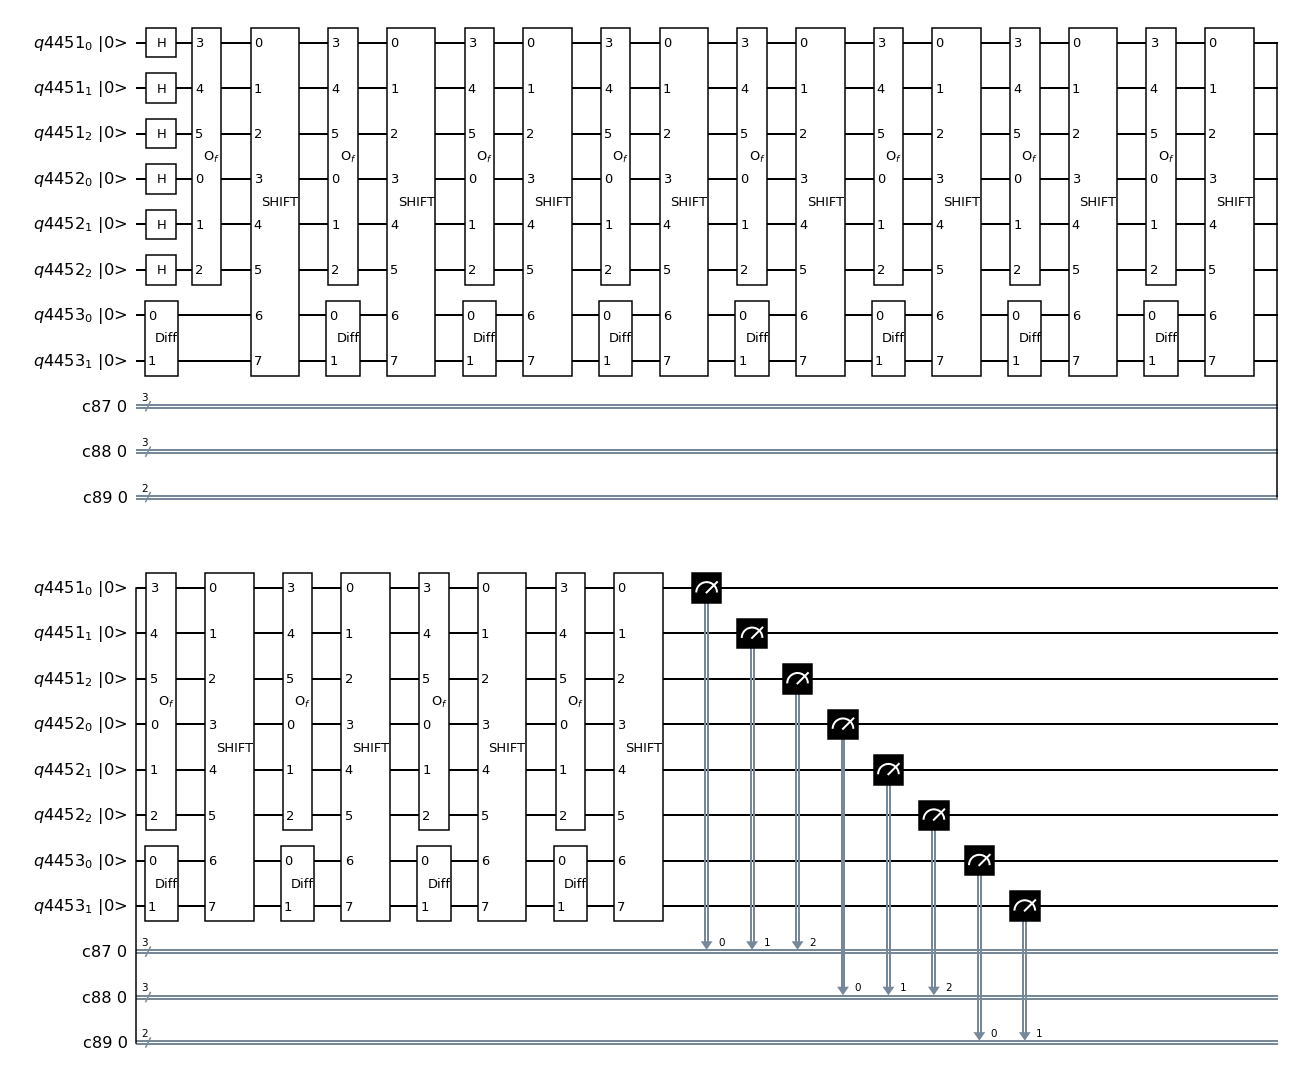

In [18]:
t = 12
n = 3

i,j = 1,3


q_reg_i = QuantumRegister(n)
q_reg_j = QuantumRegister(n)
q_coin = QuantumRegister(2)
c_reg_i = ClassicalRegister(n)
c_reg_j = ClassicalRegister(n)
c_coin = ClassicalRegister(2)


circuit = QuantumCircuit(q_reg_i, q_reg_j, q_coin, c_reg_i, c_reg_j, c_coin )

circuit.h(q_reg_i[:] + q_reg_j[:])
#circuit.h(q_coin[:])


coin = diffuser(2)
oracle = grover_oracle(n*2, i+j*2**n)
shift = shift_gate(n)
    
for _ in range(t) :
    circuit.append(coin, q_coin[:])
    circuit.append(oracle, q_reg_j[:]+ q_reg_i[:])
    circuit.append(shift, q_reg_i[:] + q_reg_j[:] + q_coin[:])
    #circuit.x( q_coin[1])


circuit.measure(q_reg_i[:] + q_reg_j[:] + q_coin[:], c_reg_i[:] + c_reg_j[:] + c_coin[:])
circuit.draw(output ='mpl', style="bw", initial_state = True , filename = 'serch_grid_circuit.png')

In [19]:
counts = simulate(circuit)
#plot_histogram(counts)

[[ 4.  3. 10. 26. 23. 22. 14. 13.]
 [ 7.  2. 27. 57. 55. 23. 17.  9.]
 [ 8.  2. 11. 41. 24. 31. 22. 11.]
 [12. 18. 13. 14. 18. 19. 14. 12.]
 [21. 11. 10. 11. 14. 10. 13. 16.]
 [13. 21. 14.  5.  7. 18. 19. 15.]
 [10.  9.  8. 12. 17. 16. 19. 11.]
 [ 5. 18. 19. 22. 16. 16. 16. 10.]]


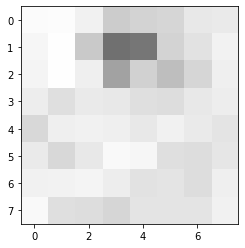

In [20]:
plt.imshow(show(n,counts)**1.3, interpolation='nearest',vmin=0, vmax=1024/3, cmap='binary')

## Search algorithm 2


$S$ is the shift gate is now defined as :


$S\left|{\leftarrow }\right\rangle \left|{i}\right\rangle \left|{j}\right\rangle =
\left|{\rightarrow }\right\rangle \left|{i+1}\right\rangle \left|{j}\right\rangle$



$S\left|{\leftarrow }\right\rangle \left|{i}\right\rangle \left|{j}\right\rangle =
\left|{\rightarrow }\right\rangle \left|{i-1}\right\rangle \left|{j}\right\rangle$



$S\left|{\downarrow }\right\rangle \left|{i}\right\rangle \left|{j}\right\rangle =
\left|{\uparrow }\right\rangle \left|{i1}\right\rangle \left|{j+1}\right\rangle$



$S\left|{\downarrow }\right\rangle \left|{i}\right\rangle \left|{j}\right\rangle =
\left|{\uparrow }\right\rangle \left|{i}\right\rangle \left|{j-1}\right\rangle$



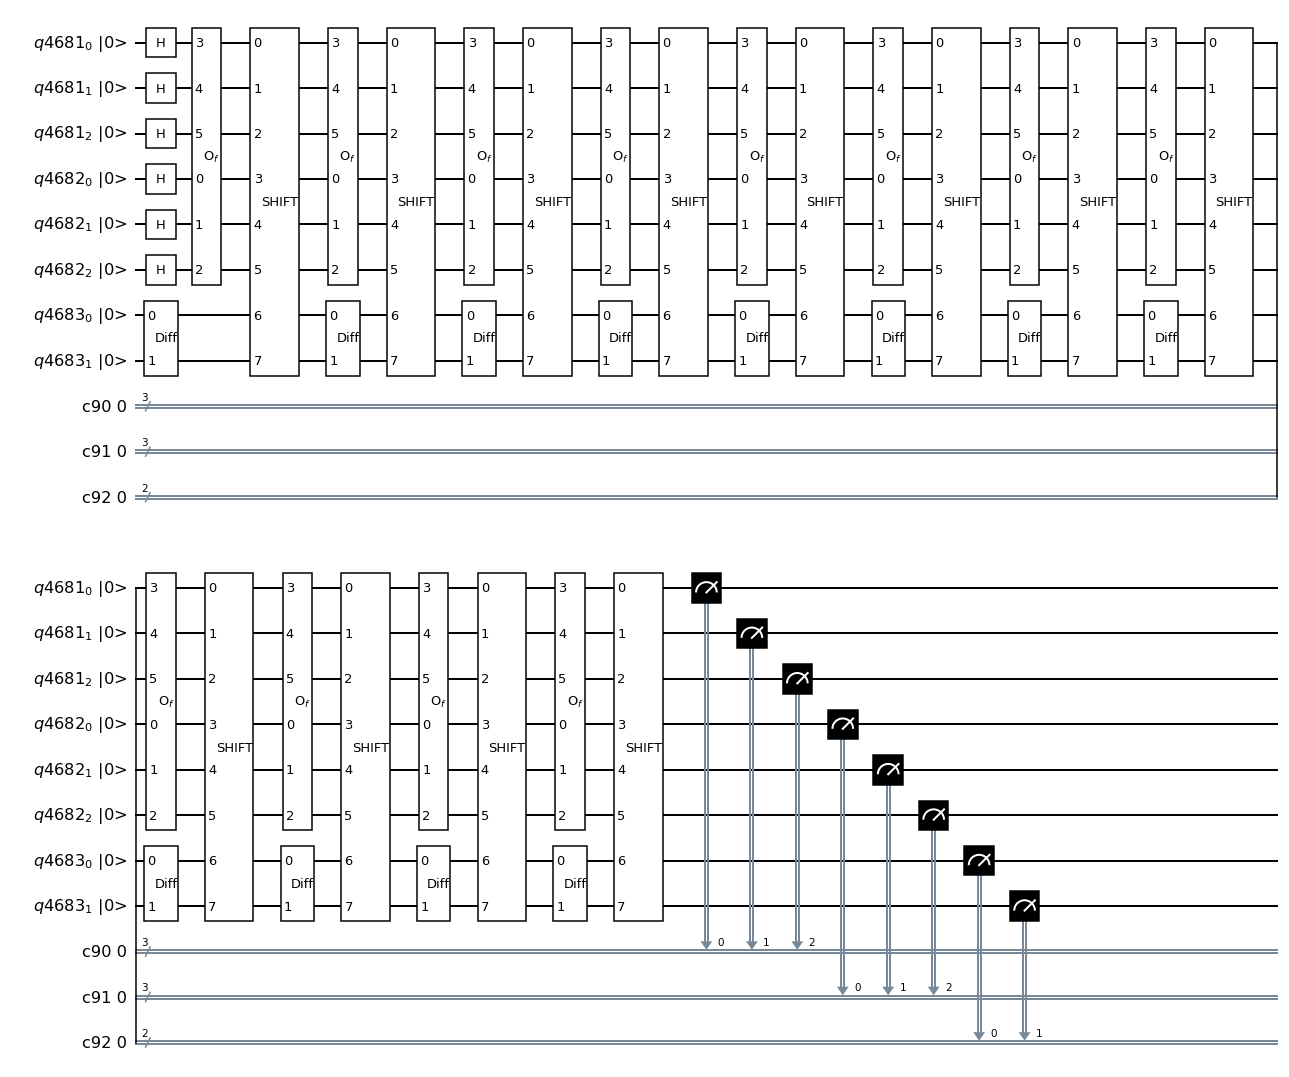

In [21]:
t = 12
n = 3

i,j = 1,3


q_reg_i = QuantumRegister(n)
q_reg_j = QuantumRegister(n)
q_coin = QuantumRegister(2)
c_reg_i = ClassicalRegister(n)
c_reg_j = ClassicalRegister(n)
c_coin = ClassicalRegister(2)


circuit = QuantumCircuit(q_reg_i, q_reg_j, q_coin, c_reg_i, c_reg_j, c_coin )

circuit.h(q_reg_i[:] + q_reg_j[:])
#circuit.h(q_coin[:])


coin = diffuser(2)
oracle = grover_oracle(n*2, i+j*2**n)
shift = shift_gate(n)
    
for _ in range(t) :
    circuit.append(coin, q_coin[:])
    circuit.append(oracle, q_reg_j[:]+ q_reg_i[:])
    circuit.append(shift, q_reg_i[:] + q_reg_j[:] + q_coin[:])


circuit.measure(q_reg_i[:] + q_reg_j[:] + q_coin[:], c_reg_i[:] + c_reg_j[:] + c_coin[:])
circuit.draw(output ='mpl', style="bw", initial_state = True )

In [22]:
counts = simulate(circuit)
#plot_histogram(counts)

[[ 8.  6. 17. 44. 19. 20. 21. 12.]
 [ 4.  0. 17. 70. 49. 25.  9.  5.]
 [ 6.  9. 11. 30. 26. 31. 10. 13.]
 [ 8.  8. 14. 23. 18. 13. 13.  8.]
 [22.  9. 10. 15. 11.  9. 20. 23.]
 [18. 20. 15.  7.  3. 14. 16. 13.]
 [21. 15. 11. 13. 11.  6. 17. 16.]
 [ 8. 14.  5. 18. 19. 28. 14. 16.]]


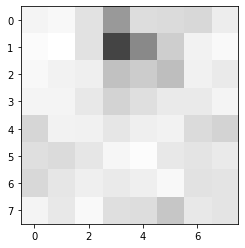

In [23]:
plt.imshow(show(n,counts)**1.3, interpolation='nearest',vmin=0, vmax=1024/3, cmap='binary')